## Pandas怎样实现groupby分组统计

类似SQL：  
select city,max(temperature) from city_weather group by city;

groupby：先对数据分组，然后在每个分组上应用聚合函数、转换函数

本次演示：  
一、分组使用聚合函数做数据统计  
二、遍历groupby的结果理解执行流程  
三、实例分组探索天气数据  

In [2]:
import pandas as pd
import numpy as np
# 加上这一句，能在jupyter notebook展示matplot图表
%matplotlib inline

In [3]:
df = pd.DataFrame({'A': ['foo', 'bar', 'foo', 'bar', 'foo', 'bar', 'foo', 'foo'],
                   'B': ['one', 'one', 'two', 'three', 'two', 'two', 'one', 'three'],
                   'C': np.random.randn(8),
                   'D': np.random.randn(8)})
df

,A,B,C,D
0,foo,one,0.699133,0.985173
1,bar,one,-1.021337,-0.354979
2,foo,two,-0.321795,-1.489767
3,bar,three,0.520036,0.840042
4,foo,two,-0.433752,-0.579994
5,bar,two,0.375011,-1.095876
6,foo,one,-0.964364,-1.271709
7,foo,three,1.016001,-0.530569


### 一、分组使用聚合函数做数据统计

#### 1、单个列groupby，查询所有数据列的统计

In [5]:
df.groupby('B').sum()

,C,D
B,,
one,-1.286567,-0.641515
three,1.536036,0.309473
two,-0.380536,-3.165637


我们看到：
1. groupby中的'A'变成了数据的索引列
2. 因为要统计sum，但B列不是数字，所以被自动忽略掉

#### 2、多个列groupby，查询所有数据列的统计

In [4]:
df.groupby(['A','B']).mean()

C         D
A   B                        
bar one   -0.375789 -0.345869
    three -1.564748  0.081163
    two   -0.202403  0.701301
foo one   -0.061143 -0.358197
    three -0.498339  0.534438
    two   -0.998504  0.632690

我们看到：('A','B')成对变成了二级索引

In [5]:
df.groupby(['A','B'], as_index=False).mean()

,A,B,C,D
0,bar,one,-0.375789,-0.345869
1,bar,three,-1.564748,0.081163
2,bar,two,-0.202403,0.701301
3,foo,one,-0.061143,-0.358197
4,foo,three,-0.498339,0.534438
5,foo,two,-0.998504,0.632690


#### 3、同时查看多种数据统计

In [6]:
df.groupby('A').agg([np.sum, np.mean, np.std])

C                             D                    
          sum      mean       std       sum      mean       std
A                                                              
bar -2.142940 -0.714313  0.741583  0.436595  0.145532  0.526544
foo -2.617633 -0.523527  0.637822  1.083423  0.216685  0.977686

我们看到：列变成了多级索引

#### 4、查看单列的结果数据统计

In [7]:
# 方法1：预过滤，性能更好
df.groupby('A')['C'].agg([np.sum, np.mean, np.std])

,sum,mean,std
A,,,
bar,-2.142940,-0.714313,0.741583
foo,-2.617633,-0.523527,0.637822


In [8]:
# 方法2
df.groupby('A').agg([np.sum, np.mean, np.std])['C']

,sum,mean,std
A,,,
bar,-2.142940,-0.714313,0.741583
foo,-2.617633,-0.523527,0.637822


#### 5、不同列使用不同的聚合函数

In [9]:
df.groupby('A').agg({"C":np.sum, "D":np.mean})

,C,D
A,,
bar,-2.142940,0.145532
foo,-2.617633,0.216685


### 二、遍历groupby的结果理解执行流程

for循环可以直接遍历每个group

##### 1、遍历单个列聚合的分组

In [10]:
g = df.groupby('A')
g

In [11]:
for name,group in g:
    print(name)
    print(group)
    print()

bar
     A      B         C         D
1  bar    one -0.375789 -0.345869
3  bar  three -1.564748  0.081163
5  bar    two -0.202403  0.701301

foo
     A      B         C         D
0  foo    one  0.542903  0.788896
2  foo    two -0.903407  0.428031
4  foo    two -1.093602  0.837348
6  foo    one -0.665189 -1.505290
7  foo  three -0.498339  0.534438



***可以获取单个分组的数据***

In [12]:
g.get_group('bar')

,A,B,C,D
1,bar,one,-0.375789,-0.345869
3,bar,three,-1.564748,0.081163
5,bar,two,-0.202403,0.701301


##### 2、遍历多个列聚合的分组

In [13]:
g = df.groupby(['A', 'B'])

In [14]:
for name,group in g:
    print(name)
    print(group)
    print()

('bar', 'one')
     A    B         C         D
1  bar  one -0.375789 -0.345869

('bar', 'three')
     A      B         C         D
3  bar  three -1.564748  0.081163

('bar', 'two')
     A    B         C         D
5  bar  two -0.202403  0.701301

('foo', 'one')
     A    B         C         D
0  foo  one  0.542903  0.788896
6  foo  one -0.665189 -1.505290

('foo', 'three')
     A      B         C         D
7  foo  three -0.498339  0.534438

('foo', 'two')
     A    B         C         D
2  foo  two -0.903407  0.428031
4  foo  two -1.093602  0.837348



可以看到，name是一个2个元素的tuple，代表不同的列

In [15]:
g.get_group(('foo', 'one'))

,A,B,C,D
0,foo,one,0.542903,0.788896
6,foo,one,-0.665189,-1.505290


***可以直接查询group后的某几列，生成Series或者子DataFrame***

In [16]:
g['C']

In [17]:
for name, group in g['C']:
    print(name)
    print(group)
    print(type(group))
    print()

('bar', 'one')
1   -0.375789
Name: C, dtype: float64
<class 'pandas.core.series.Series'>

('bar', 'three')
3   -1.564748
Name: C, dtype: float64
<class 'pandas.core.series.Series'>

('bar', 'two')
5   -0.202403
Name: C, dtype: float64
<class 'pandas.core.series.Series'>

('foo', 'one')
0    0.542903
6   -0.665189
Name: C, dtype: float64
<class 'pandas.core.series.Series'>

('foo', 'three')
7   -0.498339
Name: C, dtype: float64
<class 'pandas.core.series.Series'>

('foo', 'two')
2   -0.903407
4   -1.093602
Name: C, dtype: float64
<class 'pandas.core.series.Series'>



其实所有的聚合统计，都是在dataframe和series上进行的；

### 三、实例分组探索天气数据

In [6]:
fpath = "./datas/beijing_tianqi/beijing_tianqi_2018.csv"
df = pd.read_csv(fpath)
# 替换掉温度的后缀℃
df.loc[:, "bWendu"] = df["bWendu"].str.replace("℃", "").astype('int32')
df.loc[:, "yWendu"] = df["yWendu"].str.replace("℃", "").astype('int32')
df.head()

,ymd,bWendu,yWendu,tianqi,fengxiang,fengli,aqi,aqiInfo,aqiLevel
0,2018-01-01,3,-6,晴~多云,东北风,1-2级,59,良,2
1,2018-01-02,2,-5,阴~多云,东北风,1-2级,49,优,1
2,2018-01-03,2,-5,多云,北风,1-2级,28,优,1
3,2018-01-04,0,-8,阴,东北风,1-2级,28,优,1
4,2018-01-05,3,-6,多云~晴,西北风,1-2级,50,优,1


In [8]:
# 新增一列为月份
df['month'] = df['ymd'].str[:7]
df.head()

,ymd,bWendu,yWendu,tianqi,fengxiang,fengli,aqi,aqiInfo,aqiLevel,month
0,2018-01-01,3,-6,晴~多云,东北风,1-2级,59,良,2,2018-01
1,2018-01-02,2,-5,阴~多云,东北风,1-2级,49,优,1,2018-01
2,2018-01-03,2,-5,多云,北风,1-2级,28,优,1,2018-01
3,2018-01-04,0,-8,阴,东北风,1-2级,28,优,1,2018-01
4,2018-01-05,3,-6,多云~晴,西北风,1-2级,50,优,1,2018-01


#### 1、查看每个月的最高温度

In [9]:
data = df.groupby('month')['bWendu'].max()
data

month
2018-01     7
2018-02    12
2018-03    27
2018-04    30
2018-05    35
2018-06    38
2018-07    37
2018-08    36
2018-09    31
2018-10    25
2018-11    18
2018-12    10
Name: bWendu, dtype: int32

In [10]:
type(data)

pandas.core.series.Series

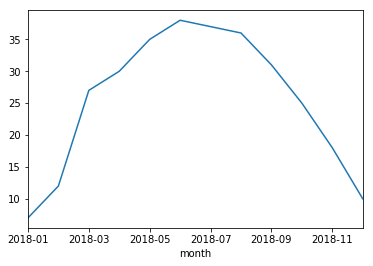

In [11]:
data.plot()

#### 2、查看每个月的最高温度、最低温度、平均空气质量指数

In [23]:
df.head()

,ymd,bWendu,yWendu,tianqi,fengxiang,fengli,aqi,aqiInfo,aqiLevel,month
0,2018-01-01,3,-6,晴~多云,东北风,1-2级,59,良,2,2018-01
1,2018-01-02,2,-5,阴~多云,东北风,1-2级,49,优,1,2018-01
2,2018-01-03,2,-5,多云,北风,1-2级,28,优,1,2018-01
3,2018-01-04,0,-8,阴,东北风,1-2级,28,优,1,2018-01
4,2018-01-05,3,-6,多云~晴,西北风,1-2级,50,优,1,2018-01


In [24]:
group_data = df.groupby('month').agg({"bWendu":np.max, "yWendu":np.min, "aqi":np.mean})
group_data

,bWendu,yWendu,aqi
month,,,
2018-01,7,-12,60.677419
2018-02,12,-10,78.857143
2018-03,27,-4,130.322581
2018-04,30,1,102.866667
2018-05,35,10,99.064516
2018-06,38,17,82.300000
2018-07,37,22,72.677419
2018-08,36,20,59.516129
2018-09,31,11,50.433333


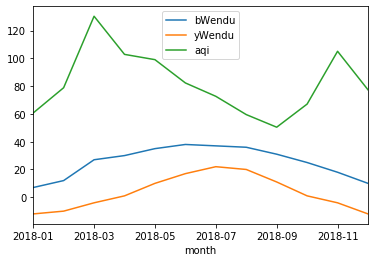

In [25]:
group_data.plot()